## Day Subject 1 vs Subject 2
The data used in this notebook is lymphocyte data for two subjects's B cells from 1 time point. We use this data to show the proteome variation between subjects. 

Here, we note presence/absense changes and quantify fold changes using a T test.


In [1]:
import longitudinalCLL
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from gprofiler import GProfiler
import numpy as np
from statistics import mean

### Access data
First, we import our data package. This brings the functions defined there into scope so we can use them in this script. Then we can create a proteomic dataset object and store it as <code>prot</code>. You can select versions and subjects with <code>load_dataset</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [2]:
prot = longitudinalCLL.get_proteomic()
prot.load_dataset(version='July_noMBR_FP', subjects = [])

prot.data_raw.head()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,2153860.2,5444238.5,5514300.50,...,0.0,4905873.00,0.0,3405266.0,4656720.00,1673629.9,6060600.5,2407679.5,7791855.0,5542659.50
A0AVT1,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,2290868.2,2486001.2,2596365.20,...,1091121.4,630647.25,576871.9,0.0,0.00,0.0,0.0,827356.1,1260652.0,0.00
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,1514363.4,866311.94,0.0,0.0,0.00,0.0,0.0,0.0,653698.6,879074.56
A6NHR9,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,1958162.5,1604476.4,418360.38,...,0.0,0.00,0.0,0.0,430484.97,0.0,0.0,0.0,538303.6,948190.40
A8K2U0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,0.0,2272656.2,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


Our next steps will require separating the runs by cell type, to compare subject 1 B cells to subject 2 B cells. As you see above, the pattern for naming the columns is Subject, B or T cell type, date, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

Note that the <code>prot</code> data is from subject 1 and subject 2, which could also be specified <code>cell_types=['Subject2_B_cells_06', 'Subject1_B_cells_06']</code>

In [3]:
cell_types=['Subject2_B_cells_06', 'Subject1_B_cells_06']

We can check which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. For our analysis, present in more than half, or at least 3 out of 5 replicates, is considered clear although it is interesting to note those proteins identified in all replicates of one type.

In [4]:
present_only_in = prot.check_presence_absence(min_reps=3, cell_types=cell_types, null_value=0).dropna()

print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =prot.data_frame.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
Subject1_B_cells_06    27
Subject2_B_cells_06    22
dtype: int64


The <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type. Be careful not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_5of5_only_in = prot.check_presence_absence(min_reps=5, cell_types=cell_types, null_value=0).dropna()

In [6]:
print("Proteins identified in 5/5 replicates only in:")
print(present_5of5_only_in.value_counts())
data_in_5of5_one_type =prot.data_frame.loc[present_5of5_only_in.index]
data_in_5of5_one_type['Type'] = present_5of5_only_in

Proteins identified in 5/5 replicates only in:
Subject2_B_cells_06    4
Subject1_B_cells_06    2
dtype: int64


### Filter data 
Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [7]:
indecies = prot.check_n_of_each_type(cell_types=cell_types, null_value=0)
prot.data_frame = prot.data_frame[indecies]

In [8]:
print ("Total groups identified:")
print(prot.data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (prot.data_frame.shape[0])

Total groups identified:
2426
Proteins identified in at least 3 of each cell type:	
1026


Before any analysis, we log normalize and median normalize across runs. We need to do this after filtering for consistently expressed proteins so those only identified in some rows do not throw off the normalization.

In [9]:
prot.normalize()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0AVT1,-1.759476,-1.355699,-0.842096,-2.114655,-0.483466,-0.961398,-1.428807,-1.544162,-1.538385,-1.407980,...,-2.719553,-3.500773,-3.665527,NaN,NaN,NaN,NaN,-2.993789,-2.400821,NaN
A8MWD9,-1.817444,-1.007690,-1.749613,-0.951311,-1.471852,NaN,-0.570884,-0.734821,-1.163683,-1.158589,...,NaN,NaN,NaN,-1.374267,-0.376917,-1.481706,-1.776836,-4.499742,-1.619399,NaN
O00148,1.644743,1.552977,1.523179,1.281036,1.012568,1.601095,1.370204,1.419392,1.146632,1.203581,...,1.298645,0.968903,1.577210,1.296702,1.462768,1.222120,1.201147,1.227091,1.368125,1.291862
O00151,0.252088,0.248345,0.134057,0.137288,0.062755,0.855874,0.935617,0.785678,0.409848,0.651788,...,-0.815120,-2.068327,-1.204812,-1.596101,NaN,-1.514581,-1.362055,-0.840671,-1.867822,-1.298172
O00170,-1.525792,-2.189973,-1.561900,NaN,NaN,-1.483434,-1.465010,-1.796148,-1.647424,-1.053485,...,-1.184886,-1.403621,-1.632491,-1.741978,-0.940369,-0.990592,-0.920990,-1.269535,-0.970507,-0.995526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P60983,0.710483,0.395528,0.373973,0.054945,0.217146,0.297022,0.203227,0.644945,-0.172911,-0.399617,...,1.059678,1.244825,1.128932,0.864062,0.496475,0.764698,0.190434,1.196989,0.072101,0.263976
P02808,-1.775096,NaN,-0.717422,-1.790280,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.051506,-2.553024,-1.857261,-1.764080,NaN,NaN,NaN,NaN,NaN,NaN
P62891,-1.603984,-1.516850,-1.581207,-1.117029,-1.368517,NaN,-0.615647,-0.432834,-0.765863,-0.624362,...,-0.630944,NaN,-0.892735,-2.644732,-0.767606,NaN,-0.337621,NaN,-0.365043,NaN


### Analysis
Now we calulate p values using a ttest. 

In [10]:
#Call ttest function
tstats = prot.ttest_wrapper(cell_types=cell_types)

Here we calculate fold change.

In [11]:
fc_comp = 'log2(2)-log2(1)'
tstats[fc_comp] = prot.get_fold_changes(cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

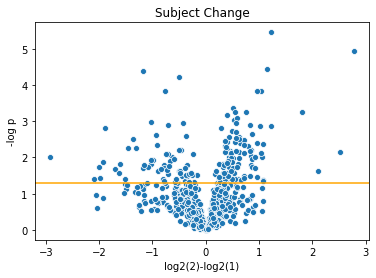

In [12]:
#graph volcano
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x=fc_comp, y='-log p',data=tstats)
figure.set_title("Subject Change")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [13]:
altered = prot.is_altered(tstats, pvalue=.05, change_factor=False,
                          change_col=fc_comp, cell_types=cell_types)

In [14]:
tstats.loc[altered.index]

,statistic,pvalue,log2(2)-log2(1),-log p
Protein ID,,,,
O14745,3.595313,0.007030,2.525937,2.153045
O15145,-2.802460,0.023110,-0.504807,1.636200
O15533,2.419286,0.041897,1.066461,1.377820
O60234,3.287417,0.011065,0.490170,1.956064
O75306,2.777580,0.024014,2.104426,1.619534
...,...,...,...,...
P16615,2.367297,0.045438,1.071991,1.342584
Q96C86,3.618638,0.006796,0.572912,2.167746
Q99497,2.710135,0.026653,0.351049,1.574262


These are significantly altered (p<0.05) without restricting by the magnitude of change:

In [15]:
altered.value_counts()

Subject2_B_cells_06    108
Subject1_B_cells_06     64
dtype: int64

In [16]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
Subject2_B_cells_06    46
Subject1_B_cells_06    39
dtype: int64

P<0.05, >200% of the other type
Subject1_B_cells_06    20
Subject2_B_cells_06    14
dtype: int64

P<0.05, >500% of the other type
Subject2_B_cells_06    2
Subject1_B_cells_06    1
dtype: int64

P<0.01, >150% of the other type
Subject2_B_cells_06    29
Subject1_B_cells_06    13
dtype: int64

P<0.01, >200% of the other type
Subject2_B_cells_06    11
Subject1_B_cells_06     7
dtype: int64

P<0.01, >500% of the other type
Subject2_B_cells_06    2
Subject1_B_cells_06    1
dtype: int64


### Differentially expressed proteins

Text(0.5, 1.0, 'Subject 1 vs Subject 2')

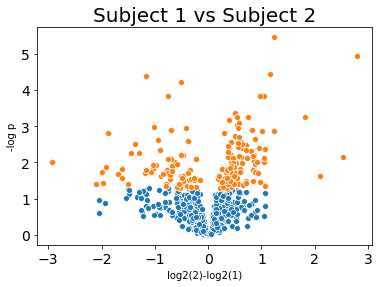

In [17]:
figure = sns.scatterplot(x=fc_comp,y='-log p',data=tstats)
figure2 = sns.scatterplot(x=fc_comp,y='-log p',
                          data=tstats.loc[altered.index])
plt.rc('axes',labelsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Subject 1 vs Subject 2", fontsize=20)

#plt.savefig("data/1_v_2.png", bbox_inches='tight', dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.


*Note that this function doesn't really have a place in the new set up yet.*

In [18]:
def load_fasta(file="data/uniprot-filtered-proteome_3AUP000005640_reviewed_human.fasta"):
    
    #file is formated:
    #>sp|Q96IY4|CBPB2_HUMAN Carboxypeptidase B2 OS=Homo sapiens OX=9606 GN=CPB2 PE=1 SV=2
    #MKLCS...
    headings = {}
    with open(file) as f:
        for line in f:
            if line.startswith('>'):#header line
                ID = line.split('|')[1]
                name=line.split('|')[2].split('=')[0].strip('OS')
                headings[ID]=name
    headings = pd.Series(list(headings.values()), index=headings.keys())
    
    return headings

In [19]:
protein_names = load_fasta()

In [20]:
protein_names_by_group={}
for ID in prot.data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in subject 1 B cells from those heightened in subject 2 B cells.

In [21]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values(fc_comp,
                        ascending=False)[['Name','GeneID',fc_comp,'pvalue']]
higher_in_group1 = altered_proteins.loc[altered_proteins[fc_comp] <0]
higher_in_group2 = altered_proteins.loc[altered_proteins[fc_comp] >0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [22]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

group1_only_geneset = data_in_one_type[(data_in_one_type.Type==cell_types[1])]
group2_only_geneset= data_in_one_type[(data_in_one_type.Type==cell_types[0])]

### Proteins Higher in Subject 1:

In [23]:
higher_in_group1

,Name,GeneID,log2(2)-log2(1),pvalue
Protein ID,,,,
Q96KP4,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2,-0.154428,0.029874
P09874,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1,-0.226343,0.047620
P29350,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6,-0.231304,0.007771
P50453,PB9_HUMAN Serpin B9,PB9,-0.263464,0.030048
Q06830,PRDX1_HUMAN Peroxiredoxin-1,PRDX1,-0.274197,0.026555
...,...,...,...,...
P05787,"K2C8_HUMAN Keratin, type II cytoskeletal 8",K2C8,-1.917591,0.013595
Q86Y46,"K2C73_HUMAN Keratin, type II cytoskeletal 73",K2C73,-1.982246,0.035771
P00491,PNPH_HUMAN Purine nucleoside phosphorylase,PNPH,-1.996959,0.018460


In [24]:
#sanity check with a couple proteins
#prot.data_frame.loc['P02775']

### Proteins Only in Subject 1:

In [25]:
group1_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O75915,PRAF3_HUMAN PRA1 family protein 3,PRAF3
P16455,MGMT_HUMAN Methylated-DNA--protein-cysteine me...,MGMT
P25311,ZA2G_HUMAN Zinc-alpha-2-glycoprotein,ZA2G
P28799,GRN_HUMAN Progranulin,GRN
P29966,MARCS_HUMAN Myristoylated alanine-rich C-kinas...,MARCS
P41218,MNDA_HUMAN Myeloid cell nuclear differentiatio...,MNDA
P47929,LEG7_HUMAN Galectin-7,LEG7
P48637,GSHB_HUMAN Glutathione synthetase,GSHB
Q02750,MP2K1_HUMAN Dual specificity mitogen-activated...,MP2K1


### Proteins higher or only in Subject 1 by GeneID
<code>group1_set</code> is defined here as both the above lists of names, those higher or only in group 1 cells.
Note that this might not be the most interesting set of proteins, ie, when comparing data that was not run together those that appear only in one time are much more likely to be run errors.

In [26]:
group1_set = list(higher_in_group1.GeneID)+list(group1_only_geneset.GeneID)

In [27]:
len(group1_set)

91

### Proteins Higher in Subject 2:

In [28]:
higher_in_group2.sort_values('pvalue', ascending=True)

,Name,GeneID,log2(2)-log2(1),pvalue
Protein ID,,,,
P14625,ENPL_HUMAN Endoplasmin,ENPL,1.232648,0.000003
P01876,IGHA1_HUMAN Immunoglobulin heavy constant alph...,IGHA1,2.786504,0.000011
P10321,HLAC_HUMAN HLA class I histocompatibility anti...,HLAC,1.158639,0.000036
P11021,BIP_HUMAN Endoplasmic reticulum chaperone BiP,BIP,0.965744,0.000142
P04439,HLAA_HUMAN HLA class I histocompatibility anti...,HLAA,1.041934,0.000145
...,...,...,...,...
P16615,AT2A2_HUMAN Sarcoplasmic/endoplasmic reticulum...,AT2A2,1.071991,0.045438
P56279,TCL1A_HUMAN T-cell leukemia/lymphoma protein 1A,TCL1A,0.426030,0.047014
Q12906,ILF3_HUMAN Interleukin enhancer-binding factor 3,ILF3,0.276465,0.048037


### Proteins Only in Subject 2:

In [29]:
group2_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00161,NP23_HUMAN Synaptosomal-associated protein 23,NP23
O95299,NDUAA_HUMAN NADH dehydrogenase [ubiquinone] 1 ...,NDUAA
O95831,"AIFM1_HUMAN Apoptosis-inducing factor 1, mitoc...",AIFM1
P06340,DOA_HUMAN HLA class II histocompatibility anti...,DOA
P23919,KTHY_HUMAN Thymidylate kinase,KTHY
P26885,FKBP2_HUMAN Peptidyl-prolyl cis-trans isomeras...,FKBP2
P33992,MCM5_HUMAN DNA replication licensing factor MCM5,MCM5
P56556,NDUA6_HUMAN NADH dehydrogenase [ubiquinone] 1 ...,NDUA6
P62306,RUXF_HUMAN Small nuclear ribonucleoprotein F,RUXF


### Proteins higher or only in Subject 2 by GeneID
<code>group2_set</code> is defined here as both the above lists of names, those higher or only in T cells.

In [30]:
group2_set = list(higher_in_group2.GeneID)+list(group2_only_geneset.GeneID)

In [31]:
len(group2_set)

130

In [32]:
#Check to see that subject 1 and subject 2 differential sets we compiled are distinct lists
#venn2(subsets = (set(group1_set), set(group2_set)), set_labels = ('subject 1', 'subject 2'))
#plt.savefig('data/diff_overlap.png')
#plt.show()

### KEGG pathway enrichment
Here I do a functional pathway enrichment. I use GProfiler to run a KEGG analysis on the differential proteins.
<code>group1_set</code> is proteins differentially expressed in Subject 1
<code>group2_set</code> is proteins differentially expressed in Subject 2

In [33]:
gp = GProfiler(return_dataframe = True)

In [34]:
group1 = gp.profile(organism='hsapiens', query=list(group1_set))
group1[group1["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


In [35]:
group2 = gp.profile(organism='hsapiens', query=list(group2_set))
group2[group2["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
96,KEGG,KEGG:03030,DNA replication,0.040211,True,DNA replication,36,36,3,8000,0.083333,0.083333,query_1,[KEGG:00000]


## Suplementary Table: Distinguished Proteins
Here we combine the data from the four categories in one dataframe and output it to a tab-separated file.

First, we get the names ofthe distinguished proteins.

In [36]:
distinguished_proteins = pd.concat([higher_in_group1, higher_in_group2])

In [37]:
distinguished_proteins

,Name,GeneID,log2(2)-log2(1),pvalue
Protein ID,,,,
Q96KP4,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2,-0.154428,0.029874
P09874,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1,-0.226343,0.047620
P29350,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6,-0.231304,0.007771
P50453,PB9_HUMAN Serpin B9,PB9,-0.263464,0.030048
Q06830,PRDX1_HUMAN Peroxiredoxin-1,PRDX1,-0.274197,0.026555
...,...,...,...,...
P25705,"ATPA_HUMAN ATP synthase subunit alpha, mitocho...",ATPA,0.252110,0.040099
P60660,MYL6_HUMAN Myosin light polypeptide 6,MYL6,0.250346,0.035480
P50552,VASP_HUMAN Vasodilator-stimulated phosphoprotein,VASP,0.220134,0.049926


Next, we get the intensity data for these proteins.

In [38]:
altered_data = prot.data_frame.loc[distinguished_proteins.index]

Next, we average by cell type, creating new columns in our <code>distinguished_proteins</code> dataframe.

In [39]:
samples=np.array(prot.data_raw.columns.values)

def mean_noNan(ser):
    ser = ser.dropna()
    if len(ser)==0:
        return np.nan
    return mean(ser)

for cell_type in cell_types:
    cells_of_type = list(s for i,s in enumerate(samples) if cell_type in s)
    type_data = altered_data[cells_of_type]
    means = type_data.apply(mean_noNan, axis=1)
    
    distinguished_proteins[("Mean {0}".format(cell_type))] = means

Here we check the column order and rearrange it as we like.

In [40]:
distinguished_proteins.columns

Index(['Name', 'GeneID', 'log2(2)-log2(1)', 'pvalue',
       'Mean Subject2_B_cells_06', 'Mean Subject1_B_cells_06'],
      dtype='object')

In [41]:
distinguished_proteins = distinguished_proteins[["GeneID", "Mean Subject2_B_cells_06", "Mean Subject1_B_cells_06", "log2(2)-log2(1)", "pvalue"]]

Here we sort the proteins. This will sort them such that high abundance in subject 1 come first, down it low abundance in subject 1, and finally sorting the subject 2 only proteins from low to high.

In [42]:
distinguished_proteins.sort_values(["Mean Subject1_B_cells_06", "Mean Subject2_B_cells_06"], ascending=[False, False], inplace=True)

<ipython-input-42-2f15c30abf0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distinguished_proteins.sort_values(["Mean Subject1_B_cells_06", "Mean Subject2_B_cells_06"], ascending=[False, False], inplace=True)


Finally, we have the finished dataframe.

In [43]:
distinguished_proteins

,GeneID,Mean Subject2_B_cells_06,Mean Subject1_B_cells_06,log2(2)-log2(1),pvalue
Protein ID,,,,,
P02042,HBD,7.381975,8.272522,-0.890547,0.023493
Q6S8J3,POTEE,6.267926,6.852621,-0.584695,0.048076
P0CG38,POTEI,5.823107,6.669237,-0.846130,0.020499
P0CG39,POTEJ,5.583899,6.617941,-1.034042,0.011757
P84243,H33,5.913657,6.397804,-0.484147,0.026887
...,...,...,...,...,...
P16615,AT2A2,-0.888831,-1.960822,1.071991,0.045438
Q9UNM6,PSD13,-1.173743,-2.050725,0.876982,0.018848
P55036,PSMD4,-1.276833,-2.206726,0.929893,0.019977


The last step is saving this dataframe to a file.

In [44]:
#distinguished_proteins.to_csv('data/distinguished_proteins_Sub1B_Day0_vs30_FP_noMBR.tsv', sep='\t')